# Random Forest Model 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import pickle
from sklearn.model_selection import ParameterGrid
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Imports raw data
housing_import = pd.read_csv('HousingDummies.csv', index_col='Id')

# Imports metrics from Linear Regression models for comparison
metrics = pickle.load( open( "metrics.p", "rb" ) )

# Loading outliers from last model
outliers = pickle.load( open( "outliers.p", "rb" ) )

In [3]:
housing_import

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,1stFlrSF,LowQualFinSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,856,0,...,0,0,0,1,0,0,0,0,1,0
2,20,80.0,9600,6,8,1976,1976,0.0,1262,0,...,0,0,0,1,0,0,0,0,1,0
3,60,68.0,11250,7,5,2001,2002,162.0,920,0,...,0,0,0,1,0,0,0,0,1,0
4,70,60.0,9550,7,5,1915,1970,0.0,961,0,...,0,0,0,1,1,0,0,0,0,0
5,60,84.0,14260,8,5,2000,2000,350.0,1145,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,953,0,...,0,0,0,1,0,0,0,0,1,0
1457,20,85.0,13175,6,6,1978,1988,119.0,2073,0,...,0,0,0,1,0,0,0,0,1,0
1458,70,66.0,9042,7,9,1941,2006,0.0,1188,0,...,0,0,0,1,0,0,0,0,1,0


In [4]:
# Creating Target and Feature Arrays
# .values returns numpy array instead of dataframe
X = housing_import.drop('SalePrice', axis=1).values
y = housing_import.SalePrice.values

In [5]:
# Shaping for regressors
#y = y.reshape(-1, 1)

In [6]:
X.shape

(1452, 273)

In [7]:
y.shape

(1452,)

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [9]:
# Create Random Forest Regressor
forest = RandomForestRegressor(n_estimators=200)

In [10]:
# Fit model to training data
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [11]:
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

0.9742536228080723
0.8907378589162028


In [12]:
# Model predictions
forest_pred_train = forest.predict(X_train)
forest_pred_test = forest.predict(X_test)

In [13]:
# Metrics for train set - Forest iteration #1
print("R^2: {}".format(forest.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_train, forest_pred_train))
print("Root Mean Squared Error: {}".format(rmse))
error = (y_train-forest_pred_train)/y_train * 100
mape = abs(error).mean()
print('Mean Absolute Percent Error: {}'.format(mape))

R^2: 0.9742536228080723
Root Mean Squared Error: 12716.442403002793
Mean Absolute Percent Error: 4.017820456492492


In [14]:
# Adding metrics to the metrics dataframe
d = {'R_Squared': [forest.score(X_train, y_train)], 'RMSE': [rmse], 'MAPE (%)': [mape],
    'Worst Underestimate':['N/A'], 'Worst Overestimate':['N/A']}
temp = pd.DataFrame(data=d, index=['Forest_Train_Initial'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

In [15]:
# Metrics for test set - Forest iteration #1
print("R^2: {}".format(forest.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, forest_pred_test))
print("Root Mean Squared Error: {}".format(rmse))
error = (y_test-forest_pred_test)/y_test * 100
mape = abs(error).mean()
print('Mean Absolute Percent Error: {}'.format(mape))

R^2: 0.8907378589162028
Root Mean Squared Error: 26180.00276250046
Mean Absolute Percent Error: 10.020664580061563


In [16]:
# Finding worst residuals for 95% 
residuals = y_test - forest_pred_test
residuals_trimmed = residuals[abs(residuals) < np.mean(residuals)+2*np.std(residuals)]
r_pos = max(residuals_trimmed)
r_neg = abs(min(residuals_trimmed))

Given a prediction "p" computed by the model, the worst case scenarios according to the tests I performed, are

In [17]:
print('p - {}'.format(r_neg))
print('p + {}'.format(r_pos))

p - 49974.98999999999
p + 51054.82999999999


In [18]:
# Adding metrics to the metrics dataframe
d = {'R_Squared': [forest.score(X_test, y_test)], 'RMSE': [rmse], 'MAPE (%)': [mape],
    'Worst Underestimate':[r_pos], 'Worst Overestimate':[r_neg]}
temp = pd.DataFrame(data=d, index=['Forest_Test_Initial'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

In [19]:
metrics

,R_Squared,RMSE,MAPE (%),Worst Underestimate,Worst Overestimate
Model,,,,,
Linear_Train,0.930668,20867.619109,8.179160,N/A,N/A
Linear_Test,0.877025,27774.277801,11.107240,54799.1,55049.2
Ridge_Train,0.924783,21735.300299,8.211178,N/A,N/A
Ridge_Test,0.894620,25710.742519,9.869781,40291,47665.9
Lasso_Train,0.930663,20868.514771,49.564078,N/A,N/A
Lasso_Test,0.887081,26614.446974,50.809840,219702,219698
Ridge_Train_a=10,0.651788,46765.919130,17.718180,N/A,N/A
Ridge_Test_a=10,0.659501,46216.022922,18.516758,90024.5,75831.5
Ridge_Train_No_Outliers,0.693021,36137.707587,17.012196,N/A,N/A


In [20]:
# Do I need to instantiate random forest regressor again? I don't think I do. 

In [21]:
# Creating a dictionary of paramteters for tuning
grid = {'n_estimators' : [100, 150, 200, 250], 'max_depth': [3, 5, 10], 
        'max_features': [4, 8, 12, 20, 25, 30, 40, 50, 60, 70],
        'random_state': [42]}
test_scores = []

In [22]:
# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    forest.set_params(**g)  # ** is "unpacking" the dictionary
    forest.fit(X_train, y_train)
    test_scores.append(forest.score(X_test, y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.897620454013031 {'random_state': 42, 'n_estimators': 100, 'max_features': 50, 'max_depth': 10}


In [23]:
# Model with for tuned paramaters

In [24]:
# Create Random Forest Regressor
forest = RandomForestRegressor(n_estimators=100, max_features=50, max_depth=10, random_state=42)

In [25]:
# Fit model to training data
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=50, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [26]:
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

0.9670992471454407
0.897620454013031


In [27]:
# Model predictions
forest_pred_train = forest.predict(X_train)
forest_pred_test = forest.predict(X_test)

In [28]:
# Metrics for train set - Forest iteration #2
print("R^2: {}".format(forest.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_train, forest_pred_train))
print("Root Mean Squared Error: {}".format(rmse))
error = (y_train-forest_pred_train)/y_train * 100
mape = abs(error).mean()
print('Mean Absolute Percent Error: {}'.format(mape))

R^2: 0.9670992471454407
Root Mean Squared Error: 14375.087030914441
Mean Absolute Percent Error: 5.78619074782995


In [29]:
# Adding metrics to the metrics dataframe
d = {'R_Squared': [forest.score(X_train, y_train)], 'RMSE': [rmse], 'MAPE (%)': [mape],
    'Worst Underestimate':['N/A'], 'Worst Overestimate':['N/A']}
temp = pd.DataFrame(data=d, index=['Forest_Train_Tuned'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

In [30]:
# Metrics for test set - Forest iteration #2
print("R^2: {}".format(forest.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, forest_pred_test))
print("Root Mean Squared Error: {}".format(rmse))
error = (y_test-forest_pred_test)/y_test * 100
mape = abs(error).mean()
print('Mean Absolute Percent Error: {}'.format(mape))

R^2: 0.897620454013031
Root Mean Squared Error: 25342.031964881167
Mean Absolute Percent Error: 9.99146585157868


In [31]:
# Finding worst residuals for 95% 
residuals = y_test - forest_pred_test
residuals_trimmed = residuals[abs(residuals) < np.mean(residuals)+2*np.std(residuals)]
r_pos = max(residuals_trimmed)
r_neg = abs(min(residuals_trimmed))

Given a prediction "p" computed by the model, the worst case scenarios according to the tests I performed, are

In [32]:
print('p - {}'.format(r_neg))
print('p + {}'.format(r_pos))

p - 48301.054530720954
p + 49009.80139933221


In [33]:
# Adding metrics to the metrics dataframe
d = {'R_Squared': [forest.score(X_test, y_test)], 'RMSE': [rmse], 'MAPE (%)': [mape],
    'Worst Underestimate':[r_pos], 'Worst Overestimate':[r_neg]}
temp = pd.DataFrame(data=d, index=['Forest_Test_Tuned'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

In [34]:
metrics

,R_Squared,RMSE,MAPE (%),Worst Underestimate,Worst Overestimate
Model,,,,,
Linear_Train,0.930668,20867.619109,8.179160,N/A,N/A
Linear_Test,0.877025,27774.277801,11.107240,54799.1,55049.2
Ridge_Train,0.924783,21735.300299,8.211178,N/A,N/A
Ridge_Test,0.894620,25710.742519,9.869781,40291,47665.9
Lasso_Train,0.930663,20868.514771,49.564078,N/A,N/A
Lasso_Test,0.887081,26614.446974,50.809840,219702,219698
Ridge_Train_a=10,0.651788,46765.919130,17.718180,N/A,N/A
Ridge_Test_a=10,0.659501,46216.022922,18.516758,90024.5,75831.5
Ridge_Train_No_Outliers,0.693021,36137.707587,17.012196,N/A,N/A


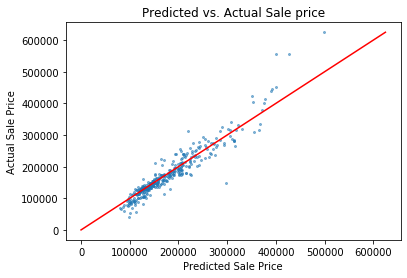

In [35]:
# Predicted vs actual scatterplot
plt.scatter(forest_pred_test, y_test, alpha=0.5, s=4)
plt.title('Predicted vs. Actual Sale price')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price')
plt.plot(list(range(y_test.max())),list(range(y_test.max())), c='r')
plt.show()

In [36]:
residuals.shape

(363,)

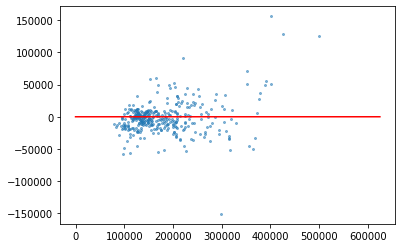

In [37]:
# Predicted vs residuals
plt.scatter(forest_pred_test, residuals, alpha = 0.5, s=4)
plt.plot(list(range(y_test.max())),[0]*y_test.max(), c='r')
plt.show()

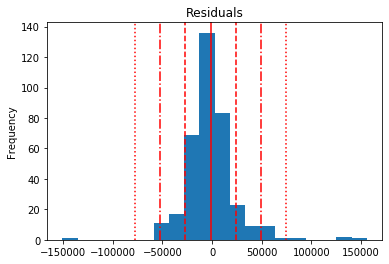

In [38]:
# Histogram of Residuals
mean = np.mean(residuals)
std_dev = np.std(residuals)

plt.hist(residuals, bins=20)
plt.axvline(mean, color='r')
plt.axvline(mean + std_dev, color='r', linestyle='--')
plt.axvline(mean + 2* std_dev, color='r', linestyle='-.')
plt.axvline(mean + 3* std_dev, color='r', linestyle=':')
plt.axvline(mean - std_dev, color='r', linestyle='--')
plt.axvline(mean - 2* std_dev, color='r', linestyle='-.')
plt.axvline(mean - 3* std_dev, color='r', linestyle=':')
plt.title('Residuals')
plt.ylabel('Frequency')
plt.show()

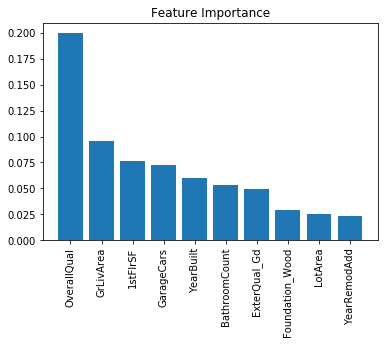

In [39]:
# Feature Importance
importances = forest.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
feature_names = housing_import.columns
labels = np.array(feature_names)[sorted_index]
plt.bar(x[0:10], importances[sorted_index][0:10], tick_label=labels[0:10])

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()

In [40]:
# Investigating outliers
# Using model on entire data set for residual analysis
forest_pred_all = forest.predict(X)
residu_all = y - forest_pred_all

In [41]:
# A set of all indicies of high outlier points
high_residuals = np.where(abs(residu_all) > mean + 3* std_dev)

In [42]:
a_set = set(high_residuals[0])

In [43]:
b_set = set(outliers.index)

In [44]:
outliers_in_both = list(a_set.intersection(b_set))
outliers_in_both

[1290, 1163, 688, 1040, 439, 1176]

In [45]:
housing_import.loc[outliers_in_both]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,1stFlrSF,LowQualFinSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1290,60,86.000000,11065,8,5,2006,2006,788.0,1120,0,...,0,1,0,0,0,0,0,0,0,1
1163,20,109.000000,8724,5,5,1968,1968,0.0,894,0,...,0,0,0,1,0,0,0,0,1,0
688,160,70.049958,5105,7,5,2004,2004,0.0,551,0,...,0,0,0,1,0,0,0,0,1,0
1040,180,21.000000,1477,4,4,1970,1970,0.0,630,0,...,0,0,0,1,0,0,0,0,1,0
439,30,40.000000,4280,5,6,1913,2002,0.0,694,0,...,0,0,0,1,0,0,0,0,1,0
1176,50,85.000000,10678,8,5,1992,2000,337.0,2129,0,...,0,0,0,1,0,0,0,0,1,0


In [46]:
# I need to find a better way of examining these points for their oddities

In [47]:
# Dropping Outliers
X_no_outliers = np.delete(X, outliers_in_both, axis=0)
y_no_outliers = np.delete(y, outliers_in_both, axis=0)

In [48]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size = 0.25, random_state=42)

In [49]:
# Create Random Forest Regressor
forest = RandomForestRegressor(n_estimators=100, max_features=50, max_depth=10, random_state=42)

In [50]:
# Fit model to training data
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=50, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [51]:
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

0.9732292004977623
0.8743383666184696


In [52]:
# Model predictions
forest_pred_train = forest.predict(X_train)
forest_pred_test = forest.predict(X_test)

In [53]:
# Metrics for train set - Forest iteration #3
print("R^2: {}".format(forest.score(X_train, y_train)))
rmse = np.sqrt(mean_squared_error(y_train, forest_pred_train))
print("Root Mean Squared Error: {}".format(rmse))
error = (y_train-forest_pred_train)/y_train * 100
mape = abs(error).mean()
print('Mean Absolute Percent Error: {}'.format(mape))

R^2: 0.9732292004977623
Root Mean Squared Error: 11864.17472770867
Mean Absolute Percent Error: 5.374570980964697


In [54]:
# Adding metrics to the metrics dataframe
d = {'R_Squared': [forest.score(X_train, y_train)], 'RMSE': [rmse], 'MAPE (%)': [mape],
    'Worst Underestimate':['N/A'], 'Worst Overestimate':['N/A']}
temp = pd.DataFrame(data=d, index=['Forest_Train_N_O'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

In [55]:
# Metrics for test set - Forest iteration #3
print("R^2: {}".format(forest.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, forest_pred_test))
print("Root Mean Squared Error: {}".format(rmse))
error = (y_test-forest_pred_test)/y_test * 100
mape = abs(error).mean()
print('Mean Absolute Percent Error: {}'.format(mape))

R^2: 0.8743383666184696
Root Mean Squared Error: 28193.940135221732
Mean Absolute Percent Error: 11.251357749470262


In [56]:
# Finding worst residuals for 95% 
residuals = y_test - forest_pred_test
residuals_trimmed = residuals[abs(residuals) < np.mean(residuals)+2*np.std(residuals)]
r_pos = max(residuals_trimmed)
r_neg = abs(min(residuals_trimmed))

Given a prediction "p" computed by the model, the worst case scenarios according to the tests I performed, are

In [57]:
print('p - {}'.format(r_neg))
print('p + {}'.format(r_pos))

p - 51446.393075312095
p + 54936.341359133075


In [58]:
# Adding metrics to the metrics dataframe
d = {'R_Squared': [forest.score(X_test, y_test)], 'RMSE': [rmse], 'MAPE (%)': [mape],
    'Worst Underestimate':[r_pos], 'Worst Overestimate':[r_neg]}
temp = pd.DataFrame(data=d, index=['Forest_Test_N_O'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

In [59]:
metrics

,R_Squared,RMSE,MAPE (%),Worst Underestimate,Worst Overestimate
Model,,,,,
Linear_Train,0.930668,20867.619109,8.179160,N/A,N/A
Linear_Test,0.877025,27774.277801,11.107240,54799.1,55049.2
Ridge_Train,0.924783,21735.300299,8.211178,N/A,N/A
Ridge_Test,0.894620,25710.742519,9.869781,40291,47665.9
Lasso_Train,0.930663,20868.514771,49.564078,N/A,N/A
Lasso_Test,0.887081,26614.446974,50.809840,219702,219698
Ridge_Train_a=10,0.651788,46765.919130,17.718180,N/A,N/A
Ridge_Test_a=10,0.659501,46216.022922,18.516758,90024.5,75831.5
Ridge_Train_No_Outliers,0.693021,36137.707587,17.012196,N/A,N/A


In [60]:
# Creating a dictionary of paramteters for tuning
grid = {'n_estimators' : [100, 150, 200, 250], 'max_depth': [3, 5, 10], 
        'max_features': [4, 8, 12, 20, 25, 30, 40, 50, 60, 70],
        'random_state': [42]}
test_scores = []

In [61]:
# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    forest.set_params(**g)  # ** is "unpacking" the dictionary
    forest.fit(X_train, y_train)
    test_scores.append(forest.score(X_test, y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.8743383666184696 {'random_state': 42, 'n_estimators': 100, 'max_features': 50, 'max_depth': 10}


The second tuning confirms the hyperparamaters of n_estimators=100, max_features=50, max_depth=10, random_state=42 is approprate for the no outliers model so the metrics do not need to be rerun. 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OO

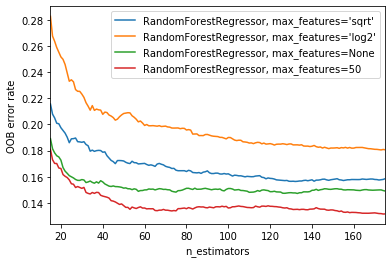

In [62]:
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=42)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=42)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=42)),
    ("RandomForestRegressor, max_features=50",
        RandomForestRegressor(warm_start=True, max_features=50,
                               oob_score=True,
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

The number of estimators seems to level out as n nears and passes 100, so the tuned model above with n_estimators will be left as 100. 

The max features provides the best error rate at 50 features. The tuned model is the best option. 